<a href="https://colab.research.google.com/github/wangscu/colab/blob/main/backtrader_grid_v002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

先经过统计学依据是均值回归后，再通过optuna找到最合适的网格交易参数。【零和游戏、仅为娱乐】

In [1]:
!pip install backtrader
!pip install yfinance
!pip install hurst
!pip install statsmodels
!pip install stochastic
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 7.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.3 MB/s eta 0:00:00


In [30]:
%matplotlib notebook
import backtrader as bt
from datetime import datetime
from math import floor, ceil
import backtrader.analyzers as btanalyzers
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import optuna
import numpy as np
import statsmodels.api as sm
from hurst import compute_Hc

symbol = "3690.HK"
start = '2022-01-01'
end = '2023-05-26'
lot = 100
cash = 70000

data = yf.download(symbol, start, end)
data.to_csv(f"{symbol}.csv")

[*********************100%***********************]  1 of 1 completed


In [3]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(data['Close'])
adfuller_test

(-2.0895205025420514,
 0.24874928566968457,
 2,
 339,
 {'1%': -3.4497880749874628,
  '5%': -2.870103829170425,
  '10%': -2.571332495975496},
 2159.389867999481)

In [4]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
data = pd.read_csv(f"{symbol}.csv", index_col=0, parse_dates=True)
sel = ar_select_order(data['Open'], 10, old_names=False)
print(f"best lags:{sel.ar_lags}")
results = sel.model.fit()
print(results.summary())

best lags:[1]
                            AutoReg Model Results                             
Dep. Variable:                   Open   No. Observations:                  342
Model:                     AutoReg(1)   Log Likelihood               -1172.318
Method:               Conditional MLE   S.D. of innovations              7.530
Date:                Sat, 03 Jun 2023   AIC                           2350.635
Time:                        11:44:12   BIC                           2362.131
Sample:                             1   HQIC                          2355.215
                                  342                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1443      2.536      2.818      0.005       2.175      12.114
Open.L1        0.9553      0.015     63.480      0.000       0.926       0.985
                                    Ro

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [5]:
data = pd.read_csv(f"{symbol}.csv", index_col=0, parse_dates=True)

hurst = compute_Hc(data['Close'], kind='price', simplified=True)
print(f"Hurst指数为：{hurst}")

# 计算半衰期
def half_life(data):
    lag = np.roll(data, 1)
    lag[0] = 0
    ret = data - lag
    ret[0] = 0
    lag2 = sm.add_constant(lag)
    model = sm.OLS(ret, lag2)
    res = model.fit()
    half_life = -np.log(2) / res.params[1]
    return half_life

half_life = half_life(data["Close"])
print("半衰期为：", half_life)

Hurst指数为：(0.5942695713502387, 0.9825001897149629, [[10, 17, 31, 56, 100, 177, 316, 342], [3.754085538462005, 5.017234379611472, 7.303545591616819, 10.880170042622327, 18.33829713929693, 24.5435002087389, 27.021236198761745, 27.861213219866325]])
半衰期为： 20.088542693407177


In [31]:
# 计算Close的均值和标准差
mu = np.mean(data['Close'])
sigma = np.std(data['Close'])
lowPrice = np.min(data['Close'])
print(f"mu:{mu}, simga:{sigma}, low:{lowPrice}")

mu:165.97953220835905, simga:26.826392189466358, low:106.0


In [32]:
class GridStrategy(bt.Strategy):
  params = (('maxPrice', 110),('width', 4),('amount', 10),('maxGridHolding', 100),('baseHolding', 0),)

  def __init__(self):
    super().__init__()
    self.maxPrice = self.params.maxPrice
    self.width = self.params.width
    self.amount = self.params.amount
    self.maxGridHolding = self.params.maxGridHolding
    self.baseHolding = self.params.baseHolding

  def next(self):
    curentPrice = self.data[0]
    gridGap = (self.maxPrice-curentPrice)/self.width

    expectHoldingAfterBuying = min(max(floor(gridGap), 0) * self.amount, self.maxGridHolding) + self.baseHolding
    expectHoldingAfterSelling = max(ceil(gridGap), 0) * self.amount + self.baseHolding

    currentHolding = self.position.size

    if currentHolding < expectHoldingAfterBuying:
      if self.broker.get_cash() >= (expectHoldingAfterBuying-currentHolding) * curentPrice:
        self.buy(size=expectHoldingAfterBuying-currentHolding)
    elif currentHolding > expectHoldingAfterSelling:
      self.sell(size=currentHolding-expectHoldingAfterSelling)

  def stop(self):
    self.close()


In [47]:
import optuna.logging as logging
logging.disable_default_handler()

def objective(trial):
    maxPrice = trial.suggest_int('maxPrice', ceil(max(0,mu-2*sigma)), floor(mu+sigma))
    width = trial.suggest_int('width', ceil(min(sigma,mu*0.05)), floor(sigma))
    amount = trial.suggest_int('amount', lot, ceil(cash/mu/lot)*lot, step=lot)

    if maxPrice * amount * 4 > cash:
      return 0

    if maxPrice - width * 4 < lowPrice:
      return 0

    cerebro = bt.Cerebro()
    cerebro.broker.setcash(cash)
    cerebro.addstrategy(GridStrategy, maxPrice=maxPrice, width=width, amount=amount, maxGridHolding=10000)
    data = bt.feeds.PandasData(dataname=pd.read_csv(f"{symbol}.csv", index_col=0, parse_dates=True))

    cerebro.adddata(data)
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='sharpratio')
    cerebro.addanalyzer(btanalyzers.Returns, _name='returns')

    result = cerebro.run()

    sharpratio = result[0].analyzers.sharpratio.get_analysis()['sharperatio']
    rtot = result[0].analyzers.returns.get_analysis()['rtot']

    return rtot or 0


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=-1)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

import optuna.visualization as vis
vis.plot_optimization_history(study)    

Best trial:
  Value:  0.4649910750990486
  Params: 
    maxPrice: 158
    width: 9
    amount: 100


{'maxPrice': 158, 'width': 9, 'amount': 100}
sharpratio:0.9433586090745552, rtot:0.4649910750990486


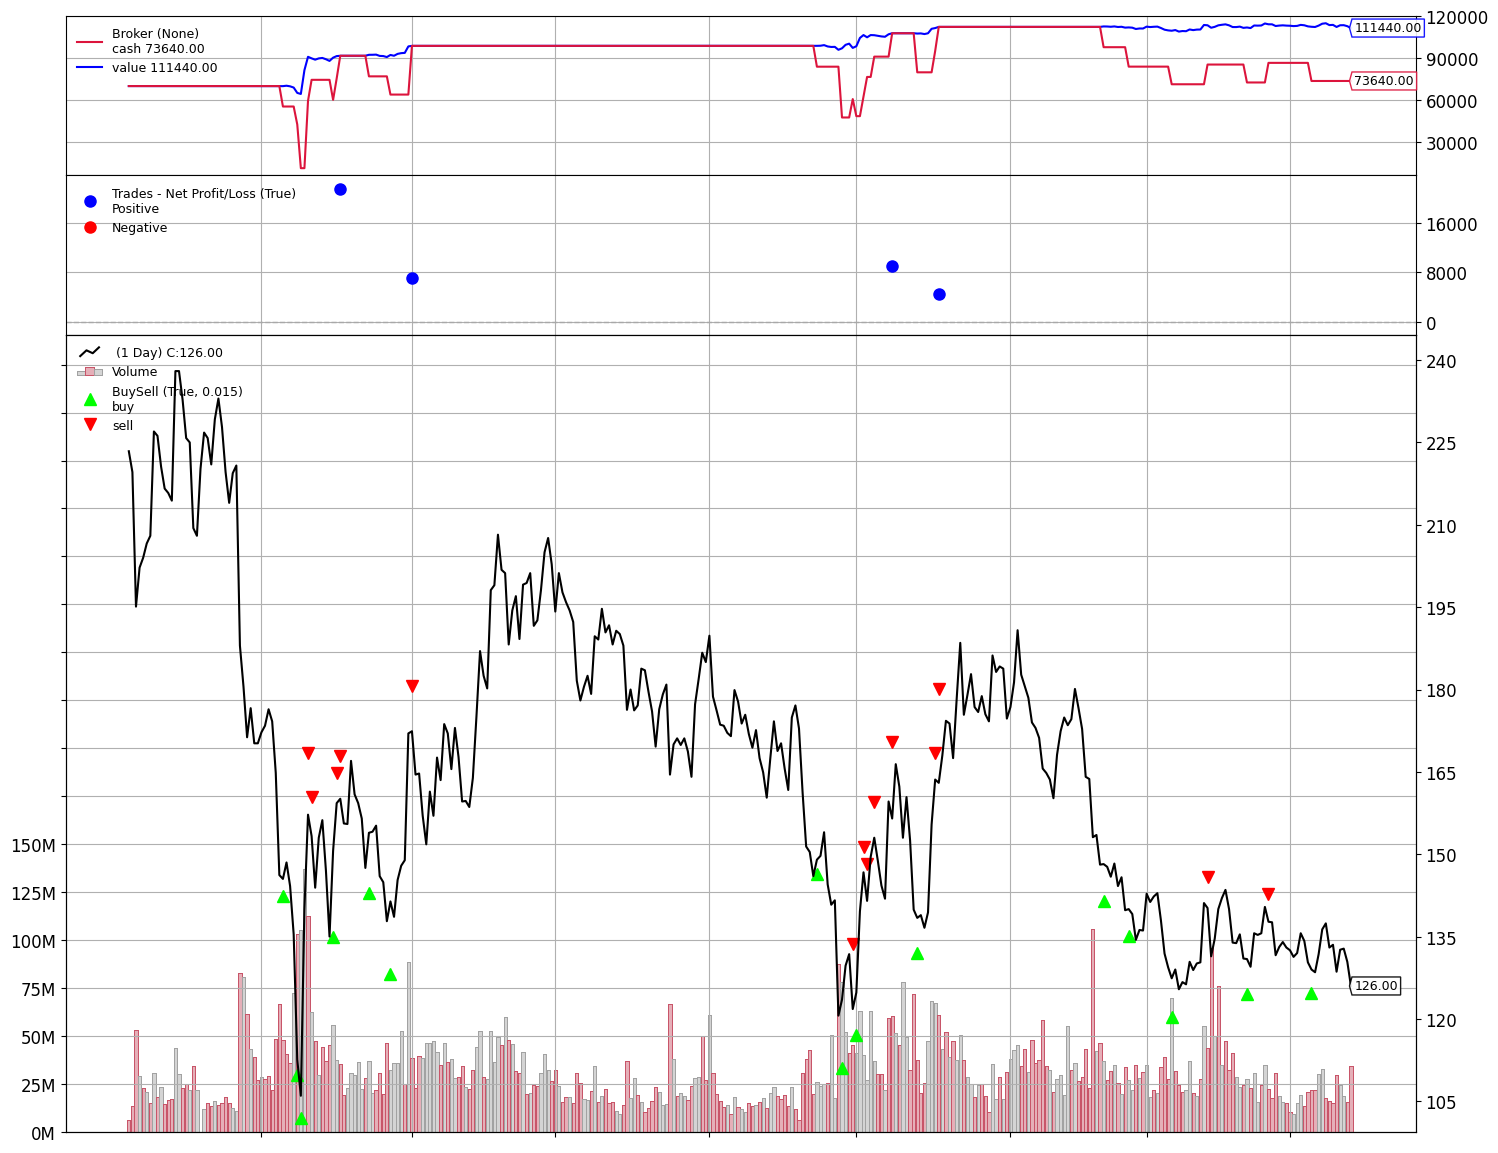

In [48]:
%matplotlib inline
print(best_trial.params)
from __future__ import (absolute_import, division, print_function, unicode_literals)

cerebro = bt.Cerebro()
cerebro.broker.setcash(cash)
cerebro.addstrategy(GridStrategy, maxPrice=best_trial.params['maxPrice'], width=best_trial.params['width'], amount=best_trial.params['amount'], maxGridHolding=10000)
data = bt.feeds.PandasData(dataname=pd.read_csv(f"{symbol}.csv", index_col=0, parse_dates=True))
cerebro.adddata(data)
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='sharpratio')
cerebro.addanalyzer(btanalyzers.Returns, _name='returns')

result = cerebro.run()
sharpratio = result[0].analyzers.sharpratio.get_analysis()['sharperatio']
rtot = result[0].analyzers.returns.get_analysis()['rtot']

print(f"sharpratio:{sharpratio}, rtot:{rtot}")

plt.rcParams['figure.figsize']=[15,12]
plt.rcParams.update({'font.size':12}) 
cerebro.plot(iplot=False)
plt.show()